In [46]:
!pip install azure-cognitiveservices-search-imagesearch
!pip install nbdev
!pip install voila
!jupyter serverextension enable voila --sys-prefix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: jupyter-core
    Found existing installation: jupyter-core 4.10.0
    Uninstalling jupyter-core-4.10.0:
      Successfully uninstalled jupyter-core-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.4.0 OK


In [4]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth
import requests
from fastai.vision.all import *
from fastdownload import download_url
from fastai.vision.widgets import *

In [5]:
key = '959a5d286b794540ab7da331f2133a60'

In [25]:
def search_images_bing(key, term, min_sz=128, max_images=150):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [26]:
results = search_images_bing(key, 'grizzly bear')

In [29]:
ims = results.attrgot('contentUrl')

In [30]:
len(ims)

150

In [27]:
dest = 'images/grizzly.jpg'

In [31]:
download_url(ims[0], dest)

Path('images/grizzly.jpg')

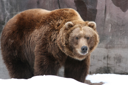

In [32]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [9]:
bear_types = ['grizzly', 'black', 'teddy']
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
fns

(#432) [Path('bears/grizzly/62381e5a-b11d-41e1-ae6d-969d86f4554f.jpg'),Path('bears/grizzly/ace6ff85-c2ee-47c4-9889-68143dba1646.jpg'),Path('bears/grizzly/7dfadb8e-4688-40b5-9514-49b6a4457d9b.jpg'),Path('bears/grizzly/91d13701-9099-4ef5-8ab5-8bc0cbfca3c7.jpg'),Path('bears/grizzly/4144eae1-3db4-46ed-a5d2-672c955e9e4d.jpg'),Path('bears/grizzly/33074f0f-3548-4b8e-98c3-8c34dbf40c20.jpg'),Path('bears/grizzly/277a9d07-b866-4528-b5fd-f4b4e488659b.jpg'),Path('bears/grizzly/4f1d8c50-b5c6-4f33-8fe3-a8301718ab97.jpg'),Path('bears/grizzly/5726eadb-5888-4b23-ad5d-6d09400000ec.jpg'),Path('bears/grizzly/76d2a8b9-abce-4ffd-bdab-3c6813457301.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#0) []

In [12]:
failed.map(Path.unlink)

(#0) []

In [16]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      /opt/conda/lib/python3.7/site-packages/fastai/vision/utils.py
Type:      function


In [13]:
bears = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=parent_label,
                 item_tfms=Resize(128))

In [14]:
dls = bears.dataloaders(path)

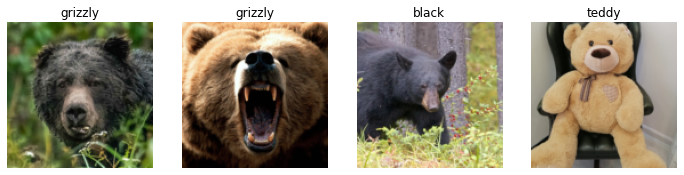

In [19]:
dls.valid.show_batch(max_n=4,nrows=1)

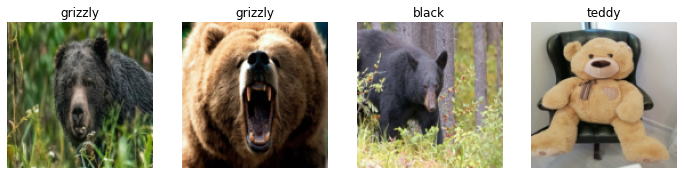

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

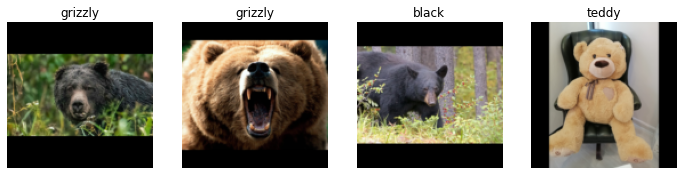

In [21]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=1)

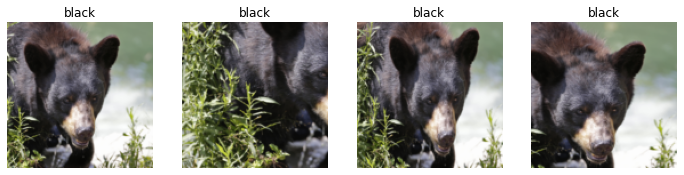

In [22]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4,nrows=1, unique=True)

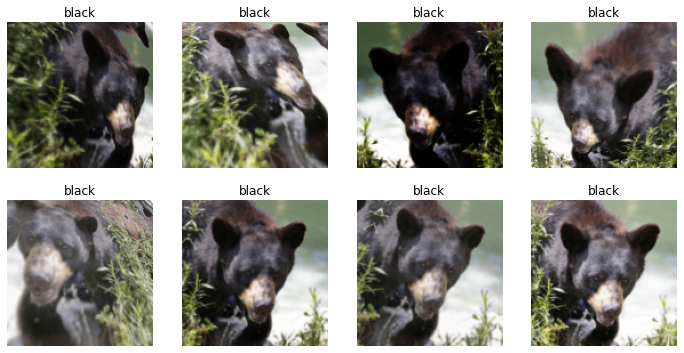

In [23]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8,nrows=2, unique=True)

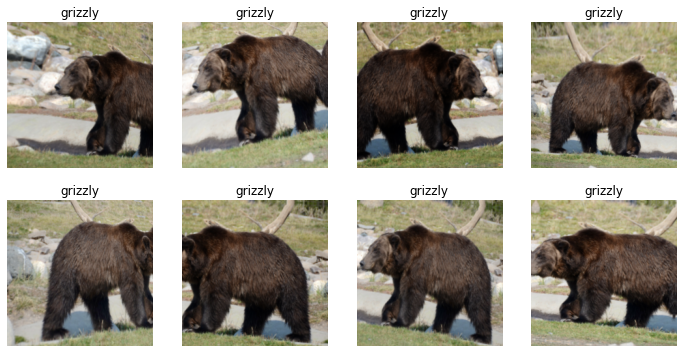

In [15]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8,nrows=2, unique=True)

In [16]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.357771,0.039660,0.011628,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.128756,0.007467,0.000000,00:44
1,0.089785,0.002664,0.000000,00:44
2,0.075917,0.001296,0.000000,00:43
3,0.060581,0.000857,0.000000,00:45


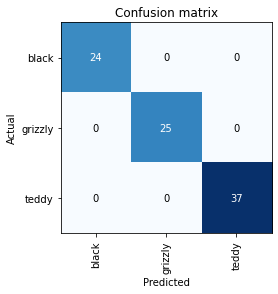

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

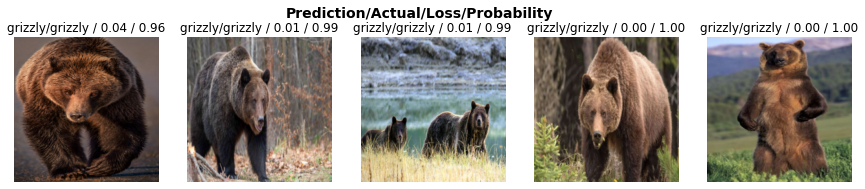

In [20]:
interp.plot_top_losses(5, nrows=1)

In [19]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [31]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

FileNotFoundError: [Errno 2] No such file or directory: 'bears/black/41d126ce-492f-4fad-975b-b76284d4c8e3.jpg'

In [32]:
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Error: Destination path 'bears/black/28da9206-3c0f-4d0e-937f-5115ea3bc9af.jpg' already exists

In [21]:
learn.export()

In [22]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [33]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([3.4614e-05, 9.9996e-01, 6.7742e-06]))

In [34]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [35]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [36]:
img = PILImage.create(btn_upload.data[-1])

In [37]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [38]:
pred, pred_idx, probs = learn_inf.predict(img)

In [40]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 1.0000')

In [41]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [44]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [45]:
VBox([widgets.Label('Select your bear!'), btn_upload, btn_run, out_pl, lbl_pred])